In [7]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
# Read data
df_items = pd.read_csv("combined_data_11thJan2024.csv")
df_orig = pd.read_excel("all_demographic_data.xlsx")
df = df_orig[df_orig["Status"] == "APPROVED"]
approved_ids = df["Participant id"].unique()
df_items = df_items[df_items["annotator_id"].isin(approved_ids)]


In [9]:
# Extract error classes
classes = []
for idx, row in df_items.iterrows():
    annots = eval(row.span_annotations)
    if annots != {}:
        for annot in annots:
            classes.append(annot["annotation"])
classes_set = set(classes)
classes = sorted(list(classes_set))


In [10]:
def map_class(span_ann, cls):
    ann = eval(span_ann)
    if ann == {}:
        return 0
    classes = []
    for annot in ann:
        classes.append(annot["annotation"])
    return 1 if cls in classes else 0

In [11]:
# Create binary errors dataframe
df_annots = df_items.drop(columns=["displayed_text", "label_annotations", "behavioral_data"])
for cls in classes:
    df_annots[cls] = df_annots["span_annotations"].apply(map_class, args=(cls,))


In [12]:
# Save full error data
df_errors_full = df_items.copy()
for cls in classes:
    df_errors_full[cls] = df_errors_full["span_annotations"].apply(lambda span_ann: 1 if cls in [annot["annotation"] for annot in eval(span_ann)] else 0)
df_errors_full.to_csv("full_error_data_extracted.csv")


In [16]:
df_binary_errs = df_annots.drop(columns=["id", "span_annotations", "annotator_id"])
df_binary_errs.head()

,Cannot pick any error category,Hallucination of information,Ignore missing information,Incorrect or vague conclusion,Incorrect understanding of the task,Non-medical factual error,Reasonable response by GPT-4,Sticking with the wrong diagnosis,Unsupported medical claim
0,0,0,0,0,0,0,0,1,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


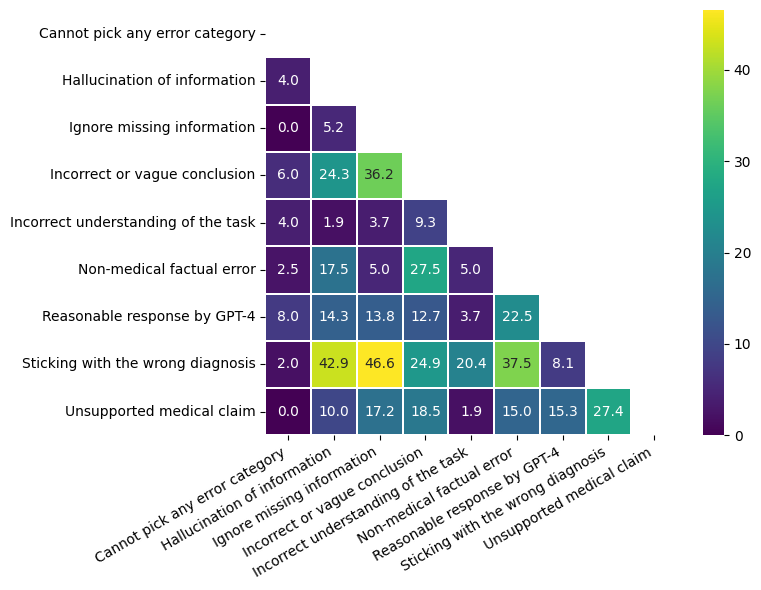

In [18]:
# Generate co-occurrence matrix
co_occ_mat = df_binary_errs.T.dot(df_binary_errs)

# Calculate co-occurrence percentage and plot heatmap
co_occ_caves = co_occ_mat.copy()
for i in range(co_occ_mat.shape[0]):
    for j in range(co_occ_mat.shape[1]):
        n_ij = co_occ_mat.iloc[i, j]
        min_c = min(co_occ_mat.iloc[i, i], co_occ_mat.iloc[j, j])
        co_occ_caves.iloc[i, j] = np.NaN if i < j or i == j else n_ij * 100 / min_c

plt.figure(figsize=(8, 6))
sns.heatmap(co_occ_caves, annot=True, cmap="viridis", fmt=".1f", linewidths=.1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [19]:
# Error Count Plot
df_strict = pd.read_csv("final_annotated_multilabel_191_points_strict.csv", encoding='latin-1' )
df_relaxed = pd.read_csv("final_annotated_multilabel_300_points_relaxed.csv")

def cls_count_from_df(df):
    stats_per_category = {}
    for cls in classes_set:
        col = df[cls]
        n = col.sum()
        perc = n / len(df_items)
        stats_per_category[len(stats_per_category)] = {"error": cls, "n": n, "perc": perc}
    return pd.DataFrame.from_dict(stats_per_category, orient='index')

strict_counts = cls_count_from_df(df_strict)
relaxed_counts = cls_count_from_df(df_relaxed)


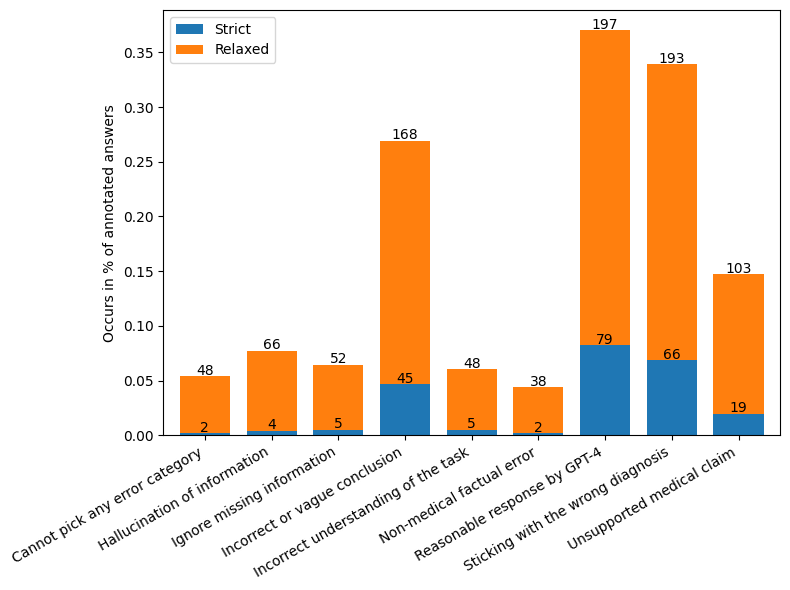

In [20]:
merged_df = pd.merge(strict_counts, relaxed_counts, on="error", suffixes=('_strict', '_relaxed'))
merged_df.sort_values(by="error", inplace=True)
merged_df.set_index("error", inplace=True)
merged_df["perc_subtracted_for_plot"] = merged_df["perc_relaxed"] + merged_df["perc_strict"]

ax = merged_df[['perc_strict', 'perc_subtracted_for_plot']].plot(kind='bar', stacked=True, figsize=(8, 6), width=0.75)
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    x, y = p.get_xy()
    error_value = merged_df.index[round(x)]
    col = "n_strict" if idx < len(ax.patches) / 2 else "n_relaxed"
    val = merged_df.loc[error_value, col]
    ax.text(x + p.get_width() / 2, y + height + 0.005, f'{val}', ha='center', va='center')

ax.set_xlabel("")
ax.set_ylabel("Occurs in % of annotated answers")
plt.xticks(rotation=30, ha="right")
ax.legend(["Strict", "Relaxed"], loc="upper left")
plt.tight_layout()
plt.show()
